In [1]:
# Install kaggle library
!pip install -q kaggle

# Upload your kaggle.json manually (small file, once only)
from google.colab import files
files.upload()  # Upload your kaggle.json here

# Move kaggle.json to the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# Download dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Unzip the dataset
!unzip -q covid19-radiography-database.zip
!ls COVID-19_Radiography_Dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [3]:
import os
import glob
import pandas as pd

# Correct categories matching actual folder names
categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Create dataframe with image paths and labels
image_paths = []
labels = []

for category in categories:
    # Path to images folder inside each disease folder
    images_folder = os.path.join('COVID-19_Radiography_Dataset', category, 'images')
    if os.path.exists(images_folder):  # Check if images folder exists
        for img_path in glob.glob(os.path.join(images_folder, '*.*')):  # Load all image types
            image_paths.append(img_path)
            labels.append(category)

# Now build DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(f"Total Images: {len(df)}")
df.sample(5)

Total Images: 21165


,image_path,label
18699,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Lung_Opacity
1160,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
3639,COVID-19_Radiography_Dataset/Normal/images/Nor...,Normal
926,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
14972,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Lung_Opacity


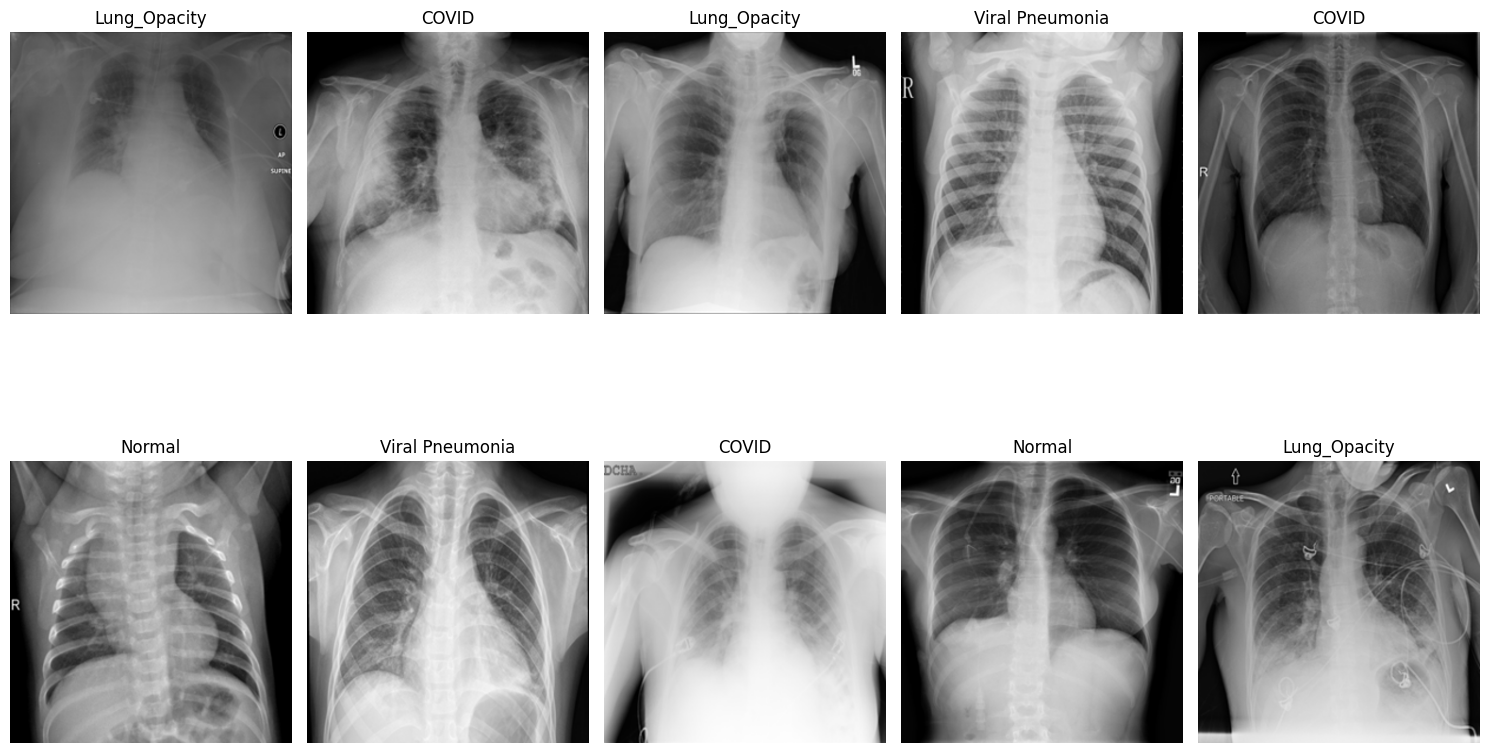

In [4]:
import matplotlib.pyplot as plt
import cv2
import random

# Plotting 10 random X-ray images
plt.figure(figsize=(15,10))

for i in range(10):
    index = random.randint(0, len(df)-1)
    img_path = df.iloc[index]['image_path']
    label = df.iloc[index]['label']

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Check the first few image paths
df['image_path'].head(10)

,image_path
0,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
1,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
2,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
3,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
4,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
5,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
6,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
7,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
8,COVID-19_Radiography_Dataset/COVID-19_Radiogra...
9,COVID-19_Radiography_Dataset/COVID-19_Radiogra...


In [11]:
import os

# The base directory where the images are stored
base_dir = 'COVID-19_Radiography_Dataset/'

# Fix the image paths to ensure the full path is correctly assigned
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(base_dir, x.split('COVID-19_Radiography_Dataset/')[-1]))

# Verify the updated paths
df['image_path'].head(10)


,image_path
0,COVID-19_Radiography_Dataset/COVID/images/COVI...
1,COVID-19_Radiography_Dataset/COVID/images/COVI...
2,COVID-19_Radiography_Dataset/COVID/images/COVI...
3,COVID-19_Radiography_Dataset/COVID/images/COVI...
4,COVID-19_Radiography_Dataset/COVID/images/COVI...
5,COVID-19_Radiography_Dataset/COVID/images/COVI...
6,COVID-19_Radiography_Dataset/COVID/images/COVI...
7,COVID-19_Radiography_Dataset/COVID/images/COVI...
8,COVID-19_Radiography_Dataset/COVID/images/COVI...
9,COVID-19_Radiography_Dataset/COVID/images/COVI...


In [12]:
df.head(10)  # Check the first few rows again


,image_path,label
0,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
1,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
3,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
5,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
6,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
7,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
8,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
9,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image size for resizing
IMG_SIZE = 128  # Resize images to this size for training

# Create ImageDataGenerators for training and validation
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random width shift
    height_shift_range=0.2,  # Random height shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill pixels after transformations
)

datagen_val = ImageDataGenerator(rescale=1./255)  # Only normalization for validation

# Create batch generators from the dataframe
train_generator = datagen_train.flow_from_dataframe(
    dataframe=df,
    directory="",  # Full paths are now correct
    x_col='image_path',
    y_col='label',
    class_mode='categorical',  # Multi-class classification
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to this size
    batch_size=32  # Batch size
)

val_generator = datagen_val.flow_from_dataframe(
    dataframe=df,
    directory="",  # Full paths already in 'image_path'
    x_col='image_path',
    y_col='label',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32
)

# Check how many images are in each generator
print(f"Training Data: {train_generator.samples} images")
print(f"Validation Data: {val_generator.samples} images")


Found 21165 validated image filenames belonging to 4 classes.
Found 21165 validated image filenames belonging to 4 classes.
Training Data: 21165 images
Validation Data: 21165 images


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# Building the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Softmax for multi-class
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
history = model.fit(
    train_generator,  # The training data generator
    validation_data=val_generator,  # The validation data generator
    epochs=10,  # Number of epochs
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # How many steps per epoch
    validation_steps=val_generator.samples // val_generator.batch_size  # How many steps for validation
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 1063s 2s/step - accuracy: 0.5815 - loss: 1.0372 - val_accuracy: 0.2839 - val_loss: 2.9768
Epoch 2/10
  1/661 ━━━━━━━━━━━━━━━━━━━━ 11:31 1s/step - accuracy: 0.6875 - loss: 0.7066

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


661/661 ━━━━━━━━━━━━━━━━━━━━ 262s 395ms/step - accuracy: 0.6875 - loss: 0.7066 - val_accuracy: 0.2840 - val_loss: 3.0683
Epoch 3/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 1106s 2s/step - accuracy: 0.6860 - loss: 0.7622 - val_accuracy: 0.4166 - val_loss: 2.2567
Epoch 4/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 235s 354ms/step - accuracy: 0.6875 - loss: 0.8644 - val_accuracy: 0.4766 - val_loss: 2.0061
Epoch 5/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 1102s 2s/step - accuracy: 0.7544 - loss: 0.6370 - val_accuracy: 0.6311 - val_loss: 0.9848
Epoch 6/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 252s 379ms/step - accuracy: 0.8438 - loss: 0.5497 - val_accuracy: 0.6398 - val_loss: 0.9978
Epoch 7/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 1036s 2s/step - accuracy: 0.7974 - loss: 0.5361 - val_accuracy: 0.6038 - val_loss: 1.1120
Epoch 8/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 264s 399ms/step - accuracy: 0.7188 - loss: 0.6066 - val_accuracy: 0.5786 - val_loss: 1.2245
Epoch 9/10
661/661 ━━━━━━━━━━━━━━━━━━━━ 1065s 2s/step - accuracy: 0.8222 - loss: 0.4765 - val

662/662 ━━━━━━━━━━━━━━━━━━━━ 229s 346ms/step - accuracy: 0.5392 - loss: 2.2821
Validation Loss: 2.228313684463501
Validation Accuracy: 0.5461375117301941


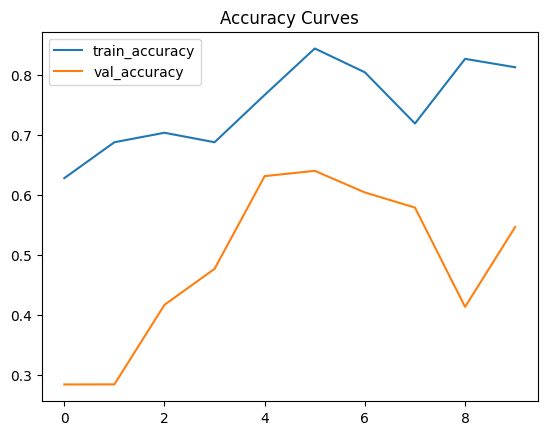

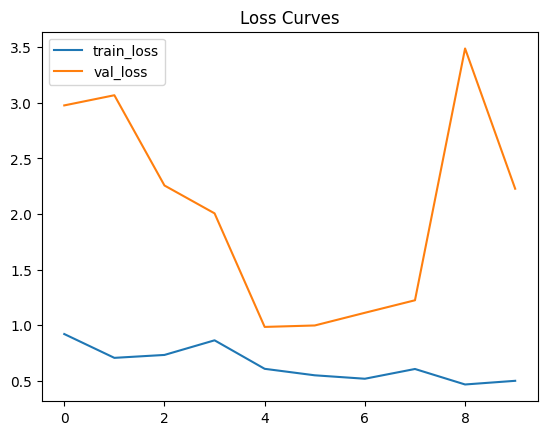

In [18]:
# Evaluate the model
score = model.evaluate(val_generator)
print(f"Validation Loss: {score[0]}")
print(f"Validation Accuracy: {score[1]}")

# Optionally, plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 + fine-tune for multi-class classification
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(categories), activation='softmax')(x)

# Create the final model
transfer_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

# Train the model (same as before)
history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 7666s 12s/step - accuracy: 0.6919 - loss: 0.8589 - val_accuracy: 0.2932 - val_loss: 1.3012
Epoch 2/10
344/662 ━━━━━━━━━━━━━━━━━━━━ 51:41 10s/step - accuracy: 0.8338 - loss: 0.4894

In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define a HyperModel for tuning
class CNNHyperModel(HyperModel):
    def build(self, hp):
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(hp.Int('units', min_value=64, max_value=512, step=64), activation='relu')(x)
        x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
        output = Dense(len(categories), activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-3, sampling='log')), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

# Instantiate and search hyperparameters
tuner = RandomSearch(CNNHyperModel(), objective='val_accuracy', max_trials=10, executions_per_trial=3, directory='my_dir', project_name='chest_xray_model')
tuner.search(train_generator, epochs=10, validation_data=val_generator)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the validation set
y_pred = transfer_model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve for each class
y_true_bin = label_binarize(y_true, classes=categories)
y_pred_bin = label_binarize(y_pred_classes, classes=categories)

for i, category in enumerate(categories):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=category)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
transfer_model.save('chest_xray_classifier.h5')